<a href="https://colab.research.google.com/github/suhyehye/dacon/blob/main/%EC%9E%A1%EC%BC%80%EC%96%B4%EC%B6%94%EC%B2%9C%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split

import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#데이터 불러오기
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')
d_code=pd.read_csv('/content/속성_D_코드.csv',index_col=0).T.to_dict()
h_code=pd.read_csv('/content/속성_H_코드.csv',index_col=0).T.to_dict()
l_code=pd.read_csv('/content/속성_L_코드.csv',index_col=0).T.to_dict()

In [5]:
#데이터중 일부 변수 제거

train = train.drop(['id', 'contents_open_dt','person_rn', 'contents_rn',
# 'person_prefer_d_1','person_prefer_d_2','person_prefer_d_3',
# 'contents_attribute_d','person_prefer_h_1','person_prefer_h_2','person_prefer_h_3','contents_attribute_h','contents_attribute_l',
'person_prefer_f','person_prefer_g'], axis=1) 


test = test.drop(['id', 'contents_open_dt','person_rn', 'contents_rn',
# 'person_prefer_d_1','person_prefer_d_2','person_prefer_d_3',
# 'contents_attribute_d','person_prefer_h_1','person_prefer_h_2','person_prefer_h_3','contents_attribute_h','contents_attribute_l',
'person_prefer_f','person_prefer_g'], axis=1)

# print(train.head())
train['d_l_match_yn']=train['d_l_match_yn'].replace([True,False],[1,0])
train['d_m_match_yn']=train['d_m_match_yn'].replace([True,False],[1,0])
train['d_s_match_yn']=train['d_s_match_yn'].replace([True,False],[1,0])
train['h_l_match_yn']=train['h_l_match_yn'].replace([True,False],[1,0])
train['h_m_match_yn']=train['h_m_match_yn'].replace([True,False],[1,0])
train['h_s_match_yn']=train['h_s_match_yn'].replace([True,False],[1,0])

test['d_l_match_yn']=test['d_l_match_yn'].replace([True,False],[1,0])
test['d_m_match_yn']=test['d_m_match_yn'].replace([True,False],[1,0])
test['d_s_match_yn']=test['d_s_match_yn'].replace([True,False],[1,0])
test['h_l_match_yn']=test['h_l_match_yn'].replace([True,False],[1,0])
test['h_m_match_yn']=test['h_m_match_yn'].replace([True,False],[1,0])
test['h_s_match_yn']=test['h_s_match_yn'].replace([True,False],[1,0])

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 랜덤 시드 고정
torch.manual_seed(42)

# GPU 사용 가능일 경우 랜덤 시드 고정
if device == 'cuda':
    torch.cuda.manual_seed_all(42)

In [7]:
#DataLoader의사용

x = train.iloc[:, :-1]
y = train.iloc[:, -1]

x= x.to_numpy()
print(x[0])
print(y[0])
# x=np.where(x > 1000, x/1000, x)
# x=np.where(x > 100, x/100, x)
# x=np.where(x > 10, x/10, x)
# x=x/10
x=torch.Tensor(x)

print(x.size())
print(x[0][1])
y=torch.Tensor(y)

print(x)
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)


dataset_train = TensorDataset(x_train, y_train)
dataloader_train = DataLoader(dataset_train, batch_size=64, shuffle=True)


dataset_valid = TensorDataset(x_valid, y_valid)
dataloader_valid = DataLoader(dataset_valid, batch_size=64, shuffle=True)


x_test=test.iloc[:]
x_test=x_test.to_numpy()
# x_test=np.where(x_test > 1000, x_test/1000, x_test)
# x_test=np.where(x_test > 100, x_test/100, x_test)
# x_test=np.where(x_test > 10, x_test/10, x_test)
# x_test=x_test/10
print(x_test.shape)
x_test=torch.FloatTensor(x_test)

[   1    1    1    0    0    0    1    4    3    5  275  370  369    8
    4   95   59    3    3   10    2    1    2 1608  275    1    4  139]
1
torch.Size([501951, 28])
tensor(1.)
tensor([[  1.,   1.,   1.,  ...,   1.,   4., 139.],
        [  0.,   0.,   0.,  ...,   1.,   4., 133.],
        [  0.,   0.,   0.,  ...,   1.,   4.,  53.],
        ...,
        [  1.,   1.,   1.,  ...,   2.,   7.,  65.],
        [  1.,   0.,   0.,  ...,   3.,   4., 259.],
        [  1.,   1.,   1.,  ...,   2.,   5., 289.]])
(46404, 28)


In [8]:



class LogisticRegression(nn.Module):
    
    def __init__(self):
        super(LogisticRegression, self).__init__()

        # self.linear = nn.Sequential(
        self.linear1=nn.Linear(28,16)
        self.batch_normal1=nn.BatchNorm1d(16)
        self.LeakRelu=nn.LeakyReLU()

        self.linear2=nn.Linear(16, 16)
        self.batch_normal2=nn.BatchNorm1d(16)
        self.LeakRelu=nn.LeakyReLU()

        self.linear3=nn.Linear(16, 16)
        self.batch_normal3=nn.BatchNorm1d(16)
        self.LeakRelu=nn.LeakyReLU()

        self.linear4=nn.Linear(16, 16)
        self.batch_normal4=nn.BatchNorm1d(16)
        self.LeakRelu=nn.LeakyReLU()

        self.linear5=nn.Linear(16, 16)
        self.batch_normal5=nn.BatchNorm1d(16)
        self.LeakRelu=nn.LeakyReLU()

        self.linear6=nn.Linear(16, 16)
        self.batch_normal6=nn.BatchNorm1d(16)
        self.LeakRelu=nn.LeakyReLU()

        self.linear7=nn.Linear(16, 1)
        self.batch_normal7=nn.BatchNorm1d(1)
        self.LeakRelu=nn.LeakyReLU()

        self.sigmoid=nn.Sigmoid()    
        torch.nn.init.xavier_uniform_(self.linear1.weight)
        torch.nn.init.xavier_uniform_(self.linear2.weight)
        torch.nn.init.xavier_uniform_(self.linear3.weight)
        torch.nn.init.xavier_uniform_(self.linear4.weight)
        torch.nn.init.xavier_uniform_(self.linear5.weight)
        torch.nn.init.xavier_uniform_(self.linear6.weight)
        torch.nn.init.xavier_uniform_(self.linear7.weight)
        # )        
#  self.linear2,self.batch_normal2, self.LeakRelu, 
        self.model=nn.Sequential(self.linear1, self.batch_normal1, self.LeakRelu,
                                 self.linear2,self.batch_normal2, self.LeakRelu, 
                                 self.linear3,self.batch_normal3,self.LeakRelu,
                                 self.linear4, self.batch_normal4,self.LeakRelu,
                                 self.linear5, self.batch_normal5,self.LeakRelu,
                                 self.linear6, self.batch_normal6,self.LeakRelu,
                                 self.linear7, self.batch_normal7,self.LeakRelu,
                                 self.sigmoid)

    def forward(self, x):
        return self.model(x)

model1=LogisticRegression().to(device)

In [9]:
criterion1=nn.CrossEntropyLoss().to(device)
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)
print(model1.parameters)


<bound method Module.parameters of LogisticRegression(
  (linear1): Linear(in_features=28, out_features=16, bias=True)
  (batch_normal1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (LeakRelu): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=16, out_features=16, bias=True)
  (batch_normal2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear3): Linear(in_features=16, out_features=16, bias=True)
  (batch_normal3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear4): Linear(in_features=16, out_features=16, bias=True)
  (batch_normal4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear5): Linear(in_features=16, out_features=16, bias=True)
  (batch_normal5): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear6): Linear(in_features=16, out_features=16, bias=True)
  (batch_normal6): Ba

In [10]:
nb_epochs = 50
accuracy_list_train=[]
accuracy_list_valid=[]
f1_list_train=[]
f1_list_valid=[]
accuracy_mean=0
f1_mean=0

# x_valid, y_valid=dataset_valid

x_valid=x_valid.to(device)
y_valid=y_valid.to(device)

for epoch in range(nb_epochs + 1):
    for batch_idx, samples in enumerate(dataloader_train):

        x_train, y_train = samples

        x_train=x_train.to(device)
        y_train=y_train.to(device)


        # H(x) 계산
        hypothesis = model1(x_train)
        
        
    
        # cost 계산
        # print(y_train.size())
        hypothesis=hypothesis.squeeze()
        # print(hypothesis.size())
        # print(hypothesis)
        # print(y_train)
        cost = F.binary_cross_entropy(hypothesis, y_train)

        # cost로 H(x) 개선
        optimizer1.zero_grad()
        cost.backward()
        optimizer1.step()

        bigo=torch.FloatTensor([0.5]).to(device)

        prediction = hypothesis >= bigo # 예측값이 0.5를 넘으면 True로 간주
        correct_prediction = prediction.float() == y_train # 실제값과 일치하는 경우만 True로 간주
        accuracy = correct_prediction.sum().item() / len(correct_prediction) # 정확도를 계산
        accuracy_mean= accuracy+accuracy_mean
        f1 = f1_score(y_train.cpu(), prediction.float().cpu())
        f1_mean=f1 + f1_mean

        # 20번마다 로그 출력
        if epoch % 10 == 0:
          if batch_idx %1000 == 0:
              prediction = hypothesis >= bigo # 예측값이 0.5를 넘으면 True로 간주
              correct_prediction = prediction.float() == y_train # 실제값과 일치하는 경우만 True로 간주
              accuracy = correct_prediction.sum().item() / len(correct_prediction) # 정확도를 계산
              f1 = f1_score(y_train.cpu(), prediction.float().cpu())
              print('Epoch {:4d}/{} Batch {}/{} Cost: {:.6f} Accuracy {:2.2f}%  f1 score : {:2.6f}'.format( # 각 에포크마다 정확도를 출력
                  epoch, nb_epochs, batch_idx+1, len(dataloader_train), cost.item(), accuracy * 100, f1
              ))

    accuracy_mean=accuracy_mean/len(dataloader_train)
    accuracy_list_train.append(accuracy_mean)
    f1_mean=f1_mean/len(dataloader_train)
    f1_list_train.append(f1_mean)

    valid_hypothesis = model1(x_valid)
    valid_hypothesis=valid_hypothesis.squeeze()
    valid_prediction = valid_hypothesis >= bigo # 예측값이 0.5를 넘으면 True로 간주
    valid_correct_prediction = valid_prediction.float() == y_valid # 실제값과 일치하는 경우만 True로 간주
    valid_accuracy = valid_correct_prediction.sum().item() / len(valid_correct_prediction) # 정확도를 계산
    # print(valid_hypothesis)
    # print(valid_prediction)
    
    # print(valid_accuracy)
    # print(len(valid_correct_prediction))
    # print(valid_correct_prediction.sum().item())
    valid_f1 = f1_score(y_valid.cpu(), valid_prediction.float().cpu())

    accuracy_list_valid.append(valid_accuracy)
    f1_list_valid.append(valid_f1)
    torch.save(model1.state_dict(), f'{epoch:04d}.pt')


Epoch    0/50 Batch 1/6275 Cost: 0.703325 Accuracy 56.25%  f1 score : 0.588235
Epoch    0/50 Batch 1001/6275 Cost: 0.676426 Accuracy 64.06%  f1 score : 0.634921
Epoch    0/50 Batch 2001/6275 Cost: 0.697574 Accuracy 50.00%  f1 score : 0.448276
Epoch    0/50 Batch 3001/6275 Cost: 0.700199 Accuracy 50.00%  f1 score : 0.483871
Epoch    0/50 Batch 4001/6275 Cost: 0.685571 Accuracy 53.12%  f1 score : 0.531250
Epoch    0/50 Batch 5001/6275 Cost: 0.705260 Accuracy 54.69%  f1 score : 0.431373
Epoch    0/50 Batch 6001/6275 Cost: 0.681382 Accuracy 51.56%  f1 score : 0.456140
Epoch   10/50 Batch 1/6275 Cost: 0.690080 Accuracy 67.19%  f1 score : 0.603774
Epoch   10/50 Batch 1001/6275 Cost: 0.679805 Accuracy 56.25%  f1 score : 0.588235
Epoch   10/50 Batch 2001/6275 Cost: 0.679963 Accuracy 59.38%  f1 score : 0.566667
Epoch   10/50 Batch 3001/6275 Cost: 0.700195 Accuracy 53.12%  f1 score : 0.500000
Epoch   10/50 Batch 4001/6275 Cost: 0.691509 Accuracy 64.06%  f1 score : 0.646154
Epoch   10/50 Batch 50

51
51


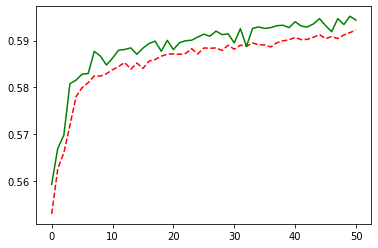

[0.5529050464807437, 0.5625399715877525, 0.5660043224390313, 0.5718730684179185, 0.5780003316974903, 0.5799261089506026, 0.5809929829124489, 0.5824564663452185, 0.5823894684939728, 0.5829223263429207, 0.5837582346336802, 0.5844439588156123, 0.5853172420651499, 0.5838814582590277, 0.5851926504315951, 0.5840466110465495, 0.5856184735635134, 0.5859457492919358, 0.5866463326559297, 0.587103781620078, 0.5871436951577615, 0.5870598701771831, 0.5872407997137069, 0.5882683849880023, 0.5871355806191215, 0.5884227506901385, 0.588352404688025, 0.5884287546992863, 0.5878817881149587, 0.5890013888639758, 0.5881574437804299, 0.5890147130056489, 0.5887915760498814, 0.589497881791668, 0.5890854777500862, 0.5890804319486455, 0.5886322239732189, 0.5895443371406066, 0.5899528490311512, 0.5901604174527008, 0.5906949790837906, 0.5901995463446084, 0.5902642084270403, 0.5907182359960308, 0.5912752472620445, 0.5904320425360843, 0.5908718151993417, 0.5904203580581991, 0.5912112887688804, 0.5917218729809459, 0.

In [11]:
import matplotlib.pyplot as plt


t=range(0,nb_epochs+1)
print(len(accuracy_list_train))
print(len(accuracy_list_valid))

plt.plot(t,accuracy_list_train,'r--',t,accuracy_list_valid,'g-')


plt.show()

print(accuracy_list_train)
print(accuracy_list_valid)

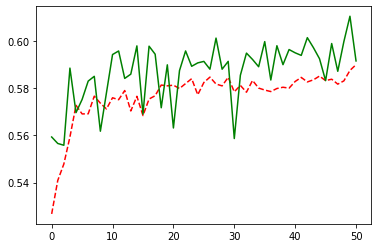

[0.5267768802619521, 0.5409115667199117, 0.5478715556198703, 0.5593142559406005, 0.5726855897646868, 0.5690484696772453, 0.5690930713106183, 0.5765719938246935, 0.5735835340452777, 0.5711577236711664, 0.575878057504658, 0.5750566470368945, 0.578929821297193, 0.5703082912134149, 0.5764903710333205, 0.5683574300396003, 0.5753429649334312, 0.5767476592793713, 0.5812517222744228, 0.5809203726371045, 0.5812030284103247, 0.579789379744488, 0.5818846452861428, 0.5839538564767097, 0.5771480085671117, 0.5823280262029636, 0.5846102006604343, 0.5816860878122272, 0.5809012325794436, 0.5845303087401114, 0.5784048093104516, 0.5811043215290881, 0.5782320374009853, 0.5831978441856178, 0.5799745160493357, 0.579145179266328, 0.578501575322032, 0.5797926302166164, 0.5803277275931138, 0.5799496510614522, 0.582767270461168, 0.584485089284749, 0.5825696554676113, 0.5834610999928977, 0.5850512875592813, 0.5831331648723651, 0.5837263319801334, 0.5816396075877387, 0.583013258015102, 0.587434232217042, 0.589872

In [12]:
plt.plot(t,f1_list_train,'r--',t,f1_list_valid,'g-')

plt.show()

print(f1_list_train)
print(f1_list_valid)

In [14]:
result=pd.read_csv('/content/sample_submission.csv')

model2=LogisticRegression()
model2.load_state_dict(torch.load('/content/0010.pt'))

x_test=x_test.to(device)
hypothesis=model2(x_test)
print(hypothesis)
prediction = hypothesis >= torch.FloatTensor([0.5]).to(device) # 예측값이 0.5를 넘으면 True로 간주

print(prediction)

prediction = torch.squeeze(prediction)
prediction=prediction.cpu()
prediction=np.array(prediction)
prediction=pd.Series(prediction)

prediction=prediction.replace([True,False],[1,0])

result['target']=prediction
result.to_csv('result.csv',index=False)

tensor([[0.4999],
        [0.4962],
        [0.4999],
        ...,
        [0.6963],
        [0.6517],
        [0.6320]], grad_fn=<SigmoidBackward0>)
tensor([[False],
        [False],
        [False],
        ...,
        [ True],
        [ True],
        [ True]])
